# US Accidents Dataset - Initial Loading and Exploration

**Objective**: Load the US Accidents dataset and perform initial exploration to understand the data structure, quality, and key characteristics.

**Dataset**: US Accidents (2016-2023)
- Source: Kaggle (sobhanmoosavi/us-accidents)
- Size: 2.9 GB, 7.7M+ records, 46 columns
- Geographic Coverage: 49 US states

## Notebook Contents
1. Environment Setup
2. Data Loading
3. Basic Statistics
4. Data Quality Assessment
5. Geographic Coverage
6. Temporal Patterns
7. Severity Distribution
8. Initial Findings

## 1. Environment Setup

In [ ]:
# Import required libraries
from enum import IntEnum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import sys

print("✓ Required packages imported")

✓ Required packages imported


In [ ]:
# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

from config import Config

# Setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✓ Environment setup complete")
print(f"Project root: {project_root}")

✓ Environment setup complete
Project root: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project


## 2. Data Loading

Let's load the dataset. We initially define optimized datatypes for improved storage & processing

In [3]:
# Show file sizes
fars_csv_names = ["accident", "drugs", "person"]
class FARS_DATA_INDEX(IntEnum):
    ACCIDENT = 0
    DRUGS = 1
    PERSON = 2
    
for filename in fars_csv_names:
    data_path = Config.FARS_RAW_DIR / f"{filename}.csv"
    print(f"File size: {data_path.stat().st_size / 1024**3:.2f} GB")

File size: 0.02 GB
File size: 0.02 GB
File size: 0.10 GB


In [4]:
# Define optimized data types
dtype_dict = {
    'ST_CASE': 'int32',
    'STATENAME': 'category',
    'PERSONS': 'int16',
    'ROUTENAME': 'category',
    'FUNC_SYSNAME': 'category',
    'RUR_URBNAME': 'category',
    'MONTH': 'int8',
    'DAY': 'int8',
    'DAY_WEEKNAME': 'category',
    'HOUR': 'int8',
    'MINUTE': 'int8',
    'FATALS': 'int8',
    'HARM_EVNAME': 'category',
    'MAN_COLLNAME': 'category',
    'RELJCT2NAME': 'category',
    'TYP_INTNAME': 'category',
    'REL_ROADNAME': 'category',
    'WRK_ZONE': 'category',
    'LGT_CONDNAME': 'category',
    'WEATHERNAME': 'category',
    'SCH_BUS': 'boolean',
    'RAIL': 'string',
    'DRUGRES': 'int16',
    'PER_TYPNAME': 'category',
    'VEH_NO': 'int8',
    'ALC_RES': 'int16',
    'INJ_SEV': 'int8',
    'AGE': 'int8'
}

print("Data type optimization configured")
print(f"Categorical columns: {sum(1 for v in dtype_dict.values() if v == 'category')}")
print(f"Boolean columns: {sum(1 for v in dtype_dict.values() if v == 'bool')}")
print(f"Float32 columns: {sum(1 for v in dtype_dict.values() if v == 'float32')}")

# Load the raw data
fars_data = [pd.DataFrame() for _ in range(len(fars_csv_names))]
for i, filename in enumerate(fars_csv_names):
    data_path = Config.FARS_RAW_DIR / f"{filename}.csv"
    fars_data[i] = pd.read_csv(data_path, dtype=dtype_dict, sep=',')
    print(f"\n✓ Dataset loaded: {len(fars_data[i]):,} rows × {len(fars_data[i].columns)} columns")
print(fars_data[FARS_DATA_INDEX.ACCIDENT].dtypes)

Data type optimization configured
Categorical columns: 14
Boolean columns: 0
Float32 columns: 0

✓ Dataset loaded: 37,654 rows × 80 columns

✓ Dataset loaded: 129,629 rows × 17 columns

✓ Dataset loaded: 92,400 rows × 126 columns
STATE                    int64
STATENAME             category
ST_CASE                  int32
PEDS                     int64
PERNOTMVIT               int64
VE_TOTAL                 int64
VE_FORMS                 int64
PVH_INVL                 int64
PERSONS                  int16
PERMVIT                  int64
COUNTY                   int64
COUNTYNAME              object
CITY                     int64
CITYNAME                object
MONTH                     int8
MONTHNAME               object
DAY                       int8
DAYNAME                  int64
DAY_WEEK                 int64
DAY_WEEKNAME          category
YEAR                     int64
HOUR                      int8
HOURNAME                object
MINUTE                    int8
MINUTENAME              ob

In [5]:
# Keep only columns of interest/drop unimportant columns
fars_accident_cols = [
    'ST_CASE', 'STATENAME', 'PERSONS', 'ROUTENAME', 'FUNC_SYSNAME',
    'RUR_URBNAME', 'MONTH', 'DAY', 'DAY_WEEKNAME', 'HOUR',
    'MINUTE', 'FATALS', 'HARM_EVNAME', 'MAN_COLLNAME', 'RELJCT2NAME',
    'TYP_INTNAME', 'REL_ROADNAME', 'WRK_ZONE', 'LGT_CONDNAME', 'WEATHERNAME',
    'SCH_BUSNAME', 'RAIL'
    ]
fars_drugs_cols = ['ST_CASE', 'PER_NO', 'DRUGRES']
fars_person_cols = ['ST_CASE', 'PER_NO', 'PER_TYP', 'VEH_NO', 'ALC_RES', 'INJ_SEV', 'AGE']
fars_cols = [fars_accident_cols, fars_drugs_cols, fars_person_cols]
for i, fars_col in enumerate(fars_cols):
    print(f"Dropping unwanted columns from {fars_csv_names[i]}:")
    fars_data[i] = fars_data[i][fars_col]
    print(f"\n✓ Columns dropped, new dataset shape is: {len(fars_data[i]):,} rows × {len(fars_data[i].columns)} columns")

Dropping unwanted columns from accident:

✓ Columns dropped, new dataset shape is: 37,654 rows × 22 columns
Dropping unwanted columns from drugs:

✓ Columns dropped, new dataset shape is: 129,629 rows × 3 columns
Dropping unwanted columns from person:

✓ Columns dropped, new dataset shape is: 92,400 rows × 7 columns


## 5. Joining FARS datasets

In [6]:
# Missing values analysis
# TODO Missing values are usually not missing but have some value that represents it being missing
# TODO personrf has indications of whether or not a drug/alcohol test was refused
missing = pd.DataFrame({
        'Column': [],
        'Missing_Count': [],
        'Missing_Percentage': []
    })
missing_vals = {
    'ROUTENAME': ['Unknown/Not Reported', 'Trafficway Not in State Inventory'],
    'RUR_URBNAME': [6, 8, 9],
    'FUNC_SYSNAME': [96, 98, 99],
    'HOUR': [99],
    'MINUTE': [99],
    'HARM_EVNAME': ['Reported as Unknown'],
    'MAN_COLLNAME': ['Unknown'],
    'RELJCT2NAME': ['Reported as Unknown', 'Not Reported'],
    'TYP_INTNAME': ['Reported as Unknown', 'Not Reported'],
    'REL_ROADNAME': ['Reported as Unknown', 'Not Reported'],
    'LGT_CONDNAME': ['Other', 'Not Reported', 'Reported as Unknown'],
    'WEATHERNAME': ['Not Reported', 'Unknown', 'Reported as Unknown'],
    'RAIL': ['9999999'],
    'DRUGRES': [9999, 9997, 9995],
    'ALC_RES': [999], #Needs more than just dealing with missing values
    'INJ_SEV': [9],
    'AGE': [99] #97 or older are all recorded as 97
}

for i, dataset in enumerate(fars_data):
    for column in dataset:
        for j, value in enumerate(dataset[column]):
            if column in missing_vals.keys() and value in missing_vals[column]:
                dataset.loc[j, column] = None

print("Replaced missing values")

for i, dataset in enumerate(fars_data):
    for column in dataset:
        new_missing_frame = pd.DataFrame({
            'Column': [f"{fars_csv_names[i]}.{column}"],
            'Missing_Count': [dataset[column].isna().sum()],
            'Missing_Percentage': [(dataset[column].isna().sum() / len(dataset[column]) * 100).round(2)]
        })
        missing = pd.concat([missing, new_missing_frame])

missing = missing[missing['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(f"Columns with missing values: {len(missing)} out of {len(dataset.columns)}")
print("\nColumns with missing data:")
missing = missing.reset_index(drop=True)
display(missing)

Replaced missing values
Columns with missing values: 14 out of 7

Columns with missing data:


,Column,Missing_Count,Missing_Percentage
0,drugs.DRUGRES,18694.00,14.42
1,accident.WEATHERNAME,1457.00,3.87
2,accident.ROUTENAME,603.00,1.60
3,person.INJ_SEV,1468.00,1.59
4,accident.MINUTE,282.00,0.75
5,accident.HOUR,282.00,0.75
6,accident.LGT_CONDNAME,281.00,0.75
7,accident.TYP_INTNAME,195.00,0.52
8,person.ALC_RES,376.00,0.41
9,accident.RELJCT2NAME,113.00,0.30


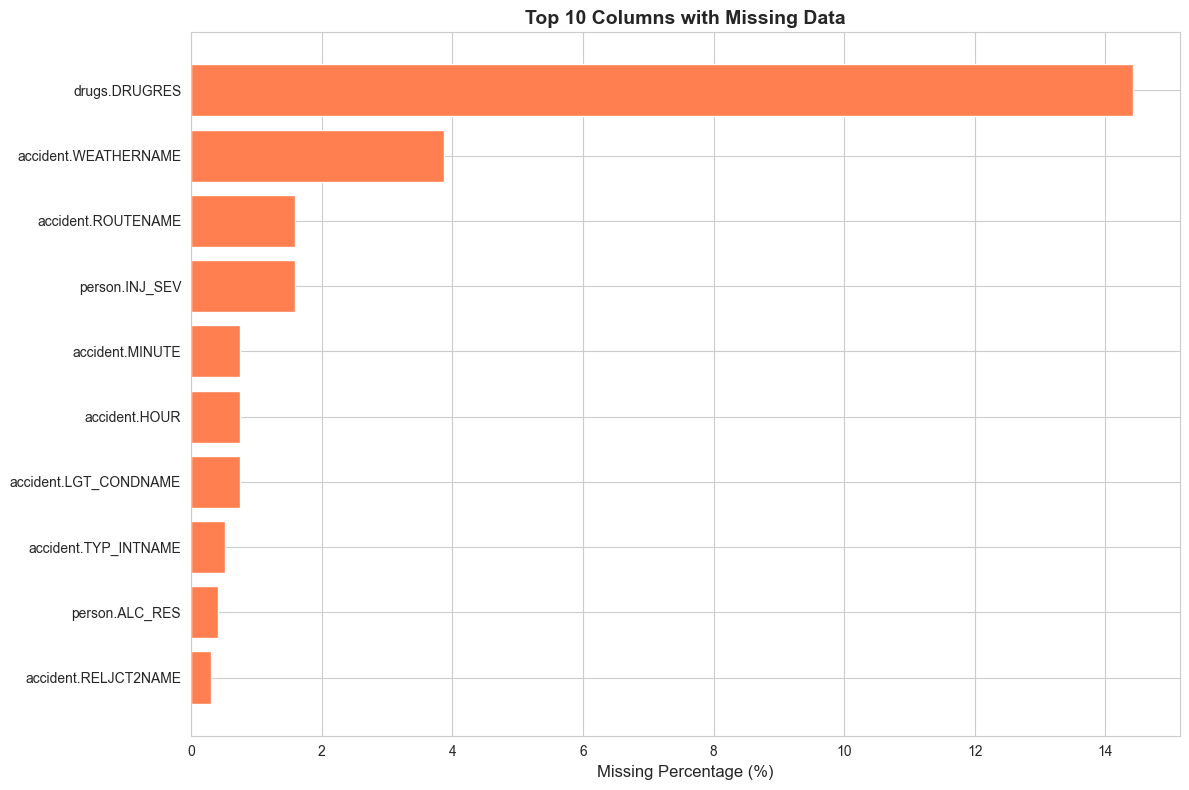

In [7]:
# Visualize missing data
fig, ax = plt.subplots(figsize=(12, 8))
missing_top = missing.head(10)
ax.barh(missing_top['Column'], missing_top['Missing_Percentage'], color='coral')
ax.set_xlabel('Missing Percentage (%)', fontsize=12)
ax.set_title('Top 10 Columns with Missing Data', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
new_cols = ['TOTAL_HARM', 'DRUNK_DRIVERS', 'DRIVERS_ON_DRUGS']
columns = fars_accident_cols + new_cols

joined_data = fars_data[FARS_DATA_INDEX.ACCIDENT].copy()
for col in new_cols:
    joined_data[col] = np.nan

for i, accident in fars_data[FARS_DATA_INDEX.ACCIDENT].iterrows():
    num_persons = accident['PERSONS']
    person_row_number = fars_data[FARS_DATA_INDEX.PERSON].index[fars_data[FARS_DATA_INDEX.PERSON]['ST_CASE'] == accident['ST_CASE']][0]
    drugs_row_number = fars_data[FARS_DATA_INDEX.DRUGS]['ST_CASE'].index[fars_data[FARS_DATA_INDEX.DRUGS]['ST_CASE'] == accident['ST_CASE']][0]
    driver_person_numbers = []
    for column in new_cols:
        if column == new_cols[0]: #Add a sum for all injuries
            total_harm = 0
            for j in range(num_persons):
                person_harm = fars_data[FARS_DATA_INDEX.PERSON].loc[person_row_number + j, 'INJ_SEV']
                if person_harm <= 4:
                    total_harm += person_harm
                elif person_harm == 5: #Injured, but unknown severity
                    total_harm += 1
            joined_data.loc[i, column] = total_harm
        elif column == new_cols[1]: #Count number of drivers who test over the limit for alcohol
            drunk_drivers = 0
            for j in range(num_persons):
                bac = fars_data[FARS_DATA_INDEX.PERSON].loc[person_row_number + j, 'ALC_RES']
                per_type = fars_data[FARS_DATA_INDEX.PERSON].loc[person_row_number + j, 'PER_TYP']
                if bac > 80 and bac not in [995, 996, 997, 998] and per_type == 1: #0.080% is the legal limit in all states, some states have additional punishments for certain higher values. Special values are assumed to be none
                    drunk_drivers += 1
                driver_person_numbers += [fars_data[FARS_DATA_INDEX.PERSON].loc[person_row_number + j, 'PER_NO']]
            joined_data.loc[i, column] = drunk_drivers
        elif column == new_cols[2]: #Count number of drivers who test positive for drugs in each accident
            drivers_on_drugs = 0
            k = 0
            while fars_data[FARS_DATA_INDEX.DRUGS].loc[drugs_row_number + k, 'ST_CASE'] == accident['ST_CASE'] and fars_data[FARS_DATA_INDEX.DRUGS].loc[drugs_row_number + k, 'PER_NO'] in driver_person_numbers:
                if fars_data[FARS_DATA_INDEX.DRUGS].loc[drugs_row_number + k, 'DRUGRES'] > 1:
                    drivers_on_drugs += 1
                    driver_person_numbers.remove(fars_data[FARS_DATA_INDEX.DRUGS].loc[drugs_row_number + k, 'PER_NO']) #Each driver on drugs should only be counted once
                k += 1
            joined_data.loc[i, column] = drivers_on_drugs
display(joined_data.head())

,ST_CASE,STATENAME,PERSONS,ROUTENAME,FUNC_SYSNAME,RUR_URBNAME,MONTH,DAY,DAY_WEEKNAME,HOUR,MINUTE,FATALS,HARM_EVNAME,MAN_COLLNAME,RELJCT2NAME,TYP_INTNAME,REL_ROADNAME,WRK_ZONE,LGT_CONDNAME,WEATHERNAME,SCH_BUSNAME,RAIL,TOTAL_HARM,DRUNK_DRIVERS,DRIVERS_ON_DRUGS
0,10001,Alabama,1,U.S. Highway,Major Collector,Rural,1,4,Wednesday,22.00,20.00,1,Rollover/Overturn,The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,0,Dark - Not Lighted,Clear,No,0000000,4.00,0.00,0.00
1,10002,Alabama,1,County,Local,Rural,3,20,Monday,2.00,0.00,1,Tree (Standing Only),The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,0,Dark - Not Lighted,Clear,No,0000000,4.00,1.00,1.00
2,10003,Alabama,1,County,Major Collector,Rural,3,18,Saturday,22.00,56.00,1,Embankment,The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,0,Dark - Not Lighted,Clear,No,0000000,4.00,1.00,0.00
3,10004,Alabama,3,County,Local,Rural,3,17,Friday,19.00,0.00,1,Live Animal,The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,0,Dark - Not Lighted,Rain,No,0000000,10.00,1.00,0.00
4,10005,Alabama,4,Interstate,Interstate,Rural,3,17,Friday,14.00,55.00,1,Tree (Standing Only),The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,0,Daylight,Rain,No,0000000,12.00,0.00,1.00


## 6. Geographic Coverage

In [9]:
# State distribution
state_counts = joined_data['STATENAME'].value_counts().head(15)
print("Top 15 States by fatal accident Count:")
print("=" * 40)
for state, count in state_counts.items():
    pct = (count / len(joined_data)) * 100
    print(f"{state:10s} {count:>10,}  ({pct:5.2f}%)")

Top 15 States by fatal accident Count:
Texas           3,874  (10.29%)
California      3,727  ( 9.90%)
Florida         3,183  ( 8.45%)
Georgia         1,491  ( 3.96%)
North Carolina      1,449  ( 3.85%)
Tennessee       1,219  ( 3.24%)
Arizona         1,195  ( 3.17%)
Ohio            1,150  ( 3.05%)
Illinois        1,143  ( 3.04%)
Pennsylvania      1,133  ( 3.01%)
New York        1,033  ( 2.74%)
Michigan        1,020  ( 2.71%)
South Carolina        976  ( 2.59%)
Missouri          905  ( 2.40%)
Alabama           893  ( 2.37%)


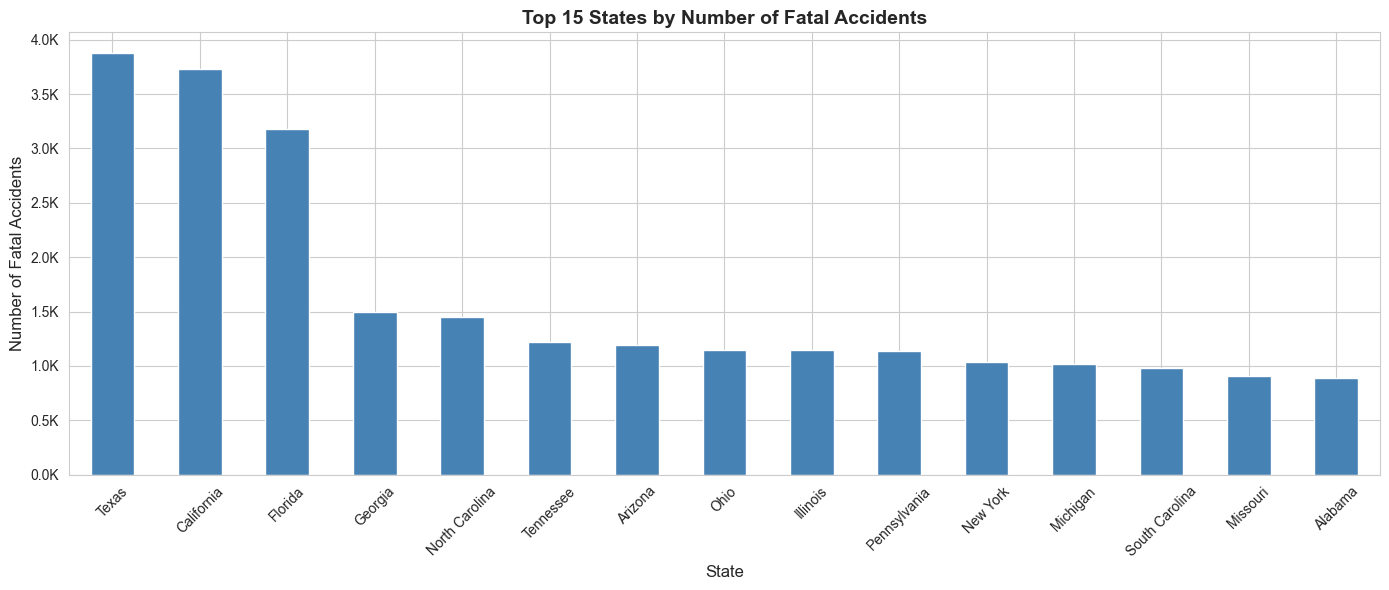

In [10]:
# Visualize state distribution
fig, ax = plt.subplots(figsize=(14, 6))
state_counts.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Top 15 States by Number of Fatal Accidents', fontsize=14, fontweight='bold')
ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('Number of Fatal Accidents', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{float(x/1000)}K'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Temporal Patterns

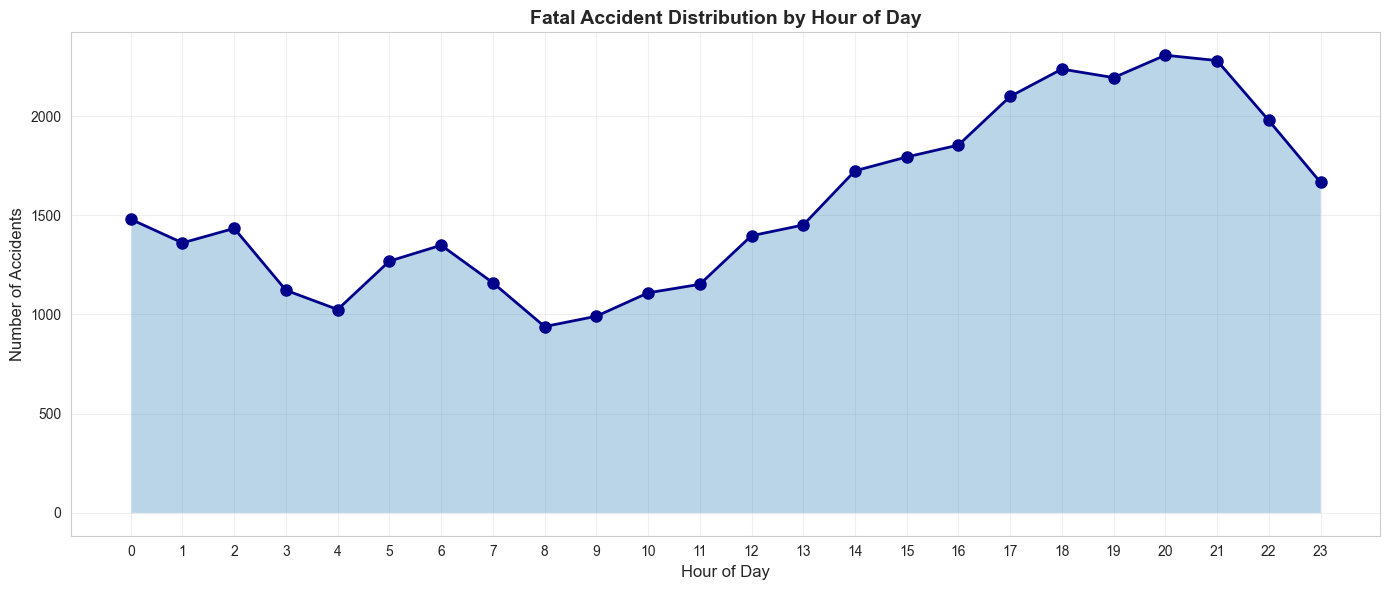

In [11]:
# Accidents by hour of day
hour_counts = joined_data['HOUR'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=8, color='darkblue')
ax.fill_between(hour_counts.index, hour_counts.values, alpha=0.3)
ax.set_title('Fatal Accident Distribution by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Accidents', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

**Common sense:** A lot of accidents happen during rush hours (Time of day) that most people commute to/from work. Lets see if the data confirms this.

In [12]:
# Identify the peak hours for accidents
peak_hours = hour_counts.sort_values(ascending=False).head(10)
min_accidents = hour_counts.min()
print("\nTop 10 Peak Hours for Accidents:\n")
for hour, count in peak_hours.items():
    print(f"At {int(hour)}h: {count:,} accidents ({count/min_accidents:.2f}x minimum)")  

print(f"\nMinimum Accidents in a Single Hour (all week): {min_accidents:,} accidents")


Top 10 Peak Hours for Accidents:

At 20h: 2,307 accidents (2.46x minimum)
At 21h: 2,280 accidents (2.43x minimum)
At 18h: 2,237 accidents (2.38x minimum)
At 19h: 2,194 accidents (2.34x minimum)
At 17h: 2,099 accidents (2.24x minimum)
At 22h: 1,978 accidents (2.11x minimum)
At 16h: 1,854 accidents (1.97x minimum)
At 15h: 1,794 accidents (1.91x minimum)
At 14h: 1,724 accidents (1.84x minimum)
At 23h: 1,666 accidents (1.77x minimum)

Minimum Accidents in a Single Hour (all week): 939 accidents


## Rush Hour Analysis

The data confirms our hypothesis about rush hour patterns. Looking at the top 10 peak hours for accidents:

**Morning Rush Hours (7-8 AM):**
- Hour 07: 587,472 accidents (7.01x minimum)
- Hour 08: 577,576 accidents (6.89x minimum)

**Evening Rush Hours (3-4 PM):**
- Hour 16: 581,969 accidents (6.94x minimum)
- Hour 17: 576,015 accidents (6.87x minimum)
- Hour 15: 525,855 accidents (6.27x minimum)


**Key Observations:**
- The highest accident count occurs at **7 AM** (587,472), marking the peak of morning commute
- Evening rush hour spans a longer period (3-4 PM) with consistently high accident rates
- These peak hours show **4.3x to 7.0x** higher accident rates compared to the minimum (83,863 at 3 AM)
- The data confirms that commute times are the most dangerous periods for driving

This pattern aligns with typical work schedules where people commute between 7-8 AM and 3-5 PM, resulting in increased traffic density and higher accident risk during these periods.

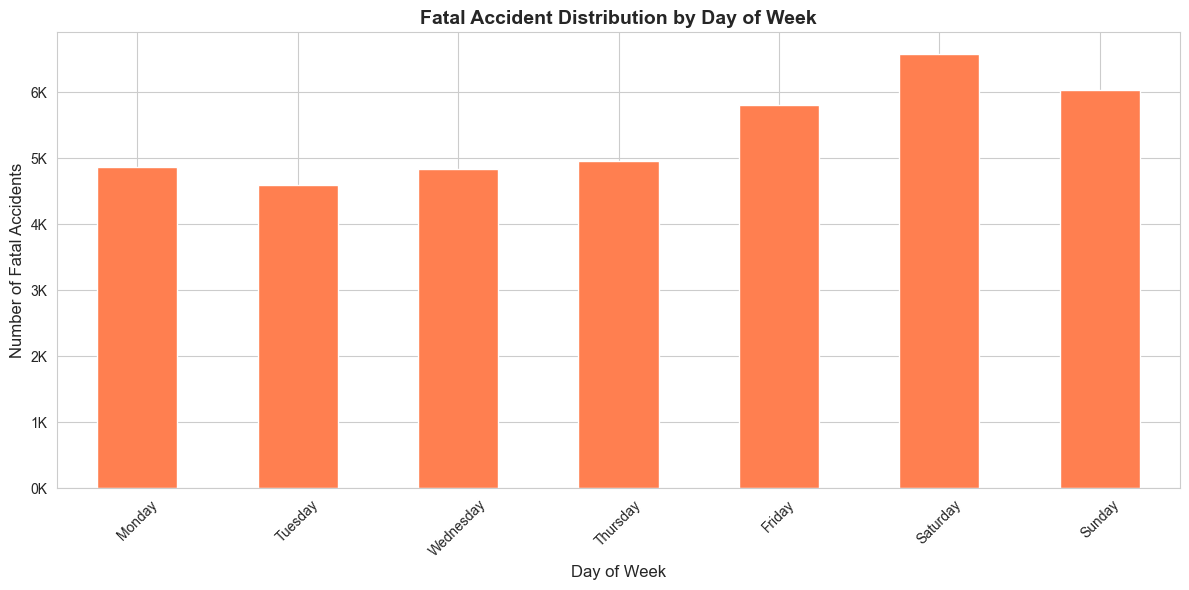

In [13]:
# Accidents by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = joined_data['DAY_WEEKNAME'].value_counts().reindex(day_order)

fig, ax = plt.subplots(figsize=(12, 6))
day_counts.plot(kind='bar', ax=ax, color='coral')
ax.set_title('Fatal Accident Distribution by Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Number of Fatal Accidents', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation:** The weekeend has a much lower number of accidents when compared to weekdays. This is likely due to lower traffic volumes as fewer people commute to work.

Lets visualize if there are still the same rush hour patterns during weekends.

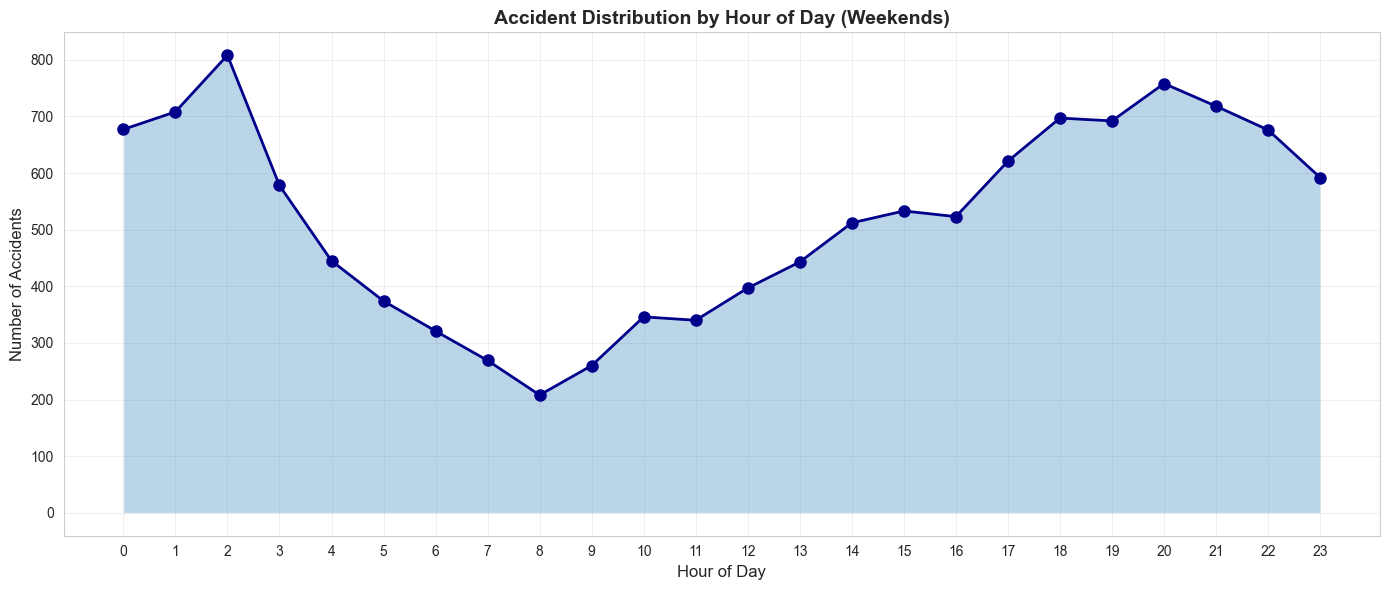


Top 10 Peak Hours for Accidents:

At 02h: 808 accidents (3.88x minimum)
At 20h: 758 accidents (3.64x minimum)
At 21h: 718 accidents (3.45x minimum)
At 01h: 708 accidents (3.40x minimum)
At 18h: 697 accidents (3.35x minimum)
At 19h: 692 accidents (3.33x minimum)
At 00h: 677 accidents (3.25x minimum)
At 22h: 676 accidents (3.25x minimum)
At 17h: 621 accidents (2.99x minimum)
At 23h: 592 accidents (2.85x minimum)

Minimum Accidents in a Single Hour (weekends): 208 accidents


In [14]:
# Accidents by hour of day on weekends

hour_counts = joined_data[joined_data['DAY_WEEKNAME'].isin(['Saturday', 'Sunday'])]['HOUR'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=8, color='darkblue')
ax.fill_between(hour_counts.index, hour_counts.values, alpha=0.3)
ax.set_title('Accident Distribution by Hour of Day (Weekends)', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Accidents', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Identify the peak hours for accidents

min_accidents = hour_counts.min()
peak_hours = hour_counts.sort_values(ascending=False).head(10)

print("\nTop 10 Peak Hours for Accidents:\n")
for hour, count in peak_hours.items():
    print(f"At {int(hour):02d}h: {count:,} accidents ({count/min_accidents:.2f}x minimum)")  

print(f"\nMinimum Accidents in a Single Hour (weekends): {min_accidents:,} accidents")

**Observation:** The rush hour patterns are less pronounced on weekends compared to weekdays. While there are still peaks in accident counts during late morning and early afternoon hours, the overall distribution is more uniform throughout the day. This suggests that weekend traffic is less influenced by traditional work commute times, leading to a more even spread of accidents across different hours.

## 8. Severity Distribution

In [15]:
# Severity distribution
severity_counts = joined_data['TOTAL_HARM'].value_counts().sort_index()

print("Accident Severity Distribution:")
print("=" * 50)
print("Level | Count      | Percentage")
print("-" * 50)
for sev, count in severity_counts.items():
    pct = (count / len(joined_data)) * 100
    print(f"  {sev}   | {count:>10,} | {pct:>6.2f}%")

print("\nNote: Severity levels 4+, sum of all casualties in each fatal accident (1 = Possible injury, 2 = Suspected minor injury, 3 = Suspected serious injury, 4 = fatality)")

Accident Severity Distribution:
Level | Count      | Percentage
--------------------------------------------------
  0.0   |         37 |   0.10%
  1.0   |         11 |   0.03%
  2.0   |         24 |   0.06%
  3.0   |         46 |   0.12%
  4.0   |     22,768 |  60.47%
  5.0   |      1,750 |   4.65%
  6.0   |      3,216 |   8.54%
  7.0   |      3,030 |   8.05%
  8.0   |      1,916 |   5.09%
  9.0   |        906 |   2.41%
  10.0   |      1,158 |   3.08%
  11.0   |        648 |   1.72%
  12.0   |        564 |   1.50%
  13.0   |        404 |   1.07%
  14.0   |        311 |   0.83%
  15.0   |        189 |   0.50%
  16.0   |        185 |   0.49%
  17.0   |        101 |   0.27%
  18.0   |         81 |   0.22%
  19.0   |         75 |   0.20%
  20.0   |         61 |   0.16%
  21.0   |         37 |   0.10%
  22.0   |         32 |   0.08%
  23.0   |         20 |   0.05%
  24.0   |         11 |   0.03%
  25.0   |         12 |   0.03%
  26.0   |          8 |   0.02%
  27.0   |          6 |   0.02%

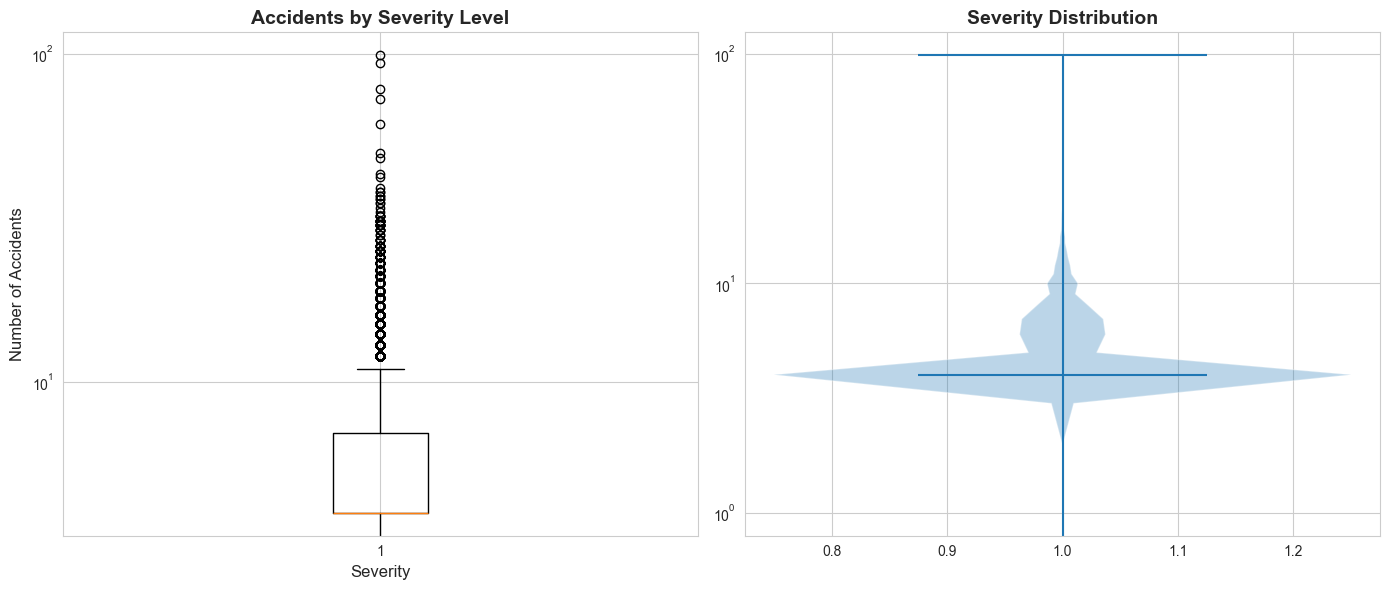

In [16]:
# Visualize severity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
ax1.boxplot(joined_data['TOTAL_HARM'])
ax1.set_title('Accidents by Severity Level', fontsize=14, fontweight='bold')
ax1.semilogy()
ax1.set_xlabel('Severity', fontsize=12)
ax1.set_ylabel('Number of Accidents', fontsize=12)

# Violin plot
ax2.violinplot(joined_data['TOTAL_HARM'], showmeans=False, showmedians=True)
ax2.set_title('Severity Distribution', fontsize=14, fontweight='bold')
ax2.semilogy()

plt.tight_layout()
plt.show()

## 9. Weather Conditions

In [17]:
# Top weather conditions
weather_counts = joined_data['WEATHERNAME'].value_counts().head(15)

print("Top 15 Weather Conditions:")
print("=" * 60)
for i, (weather, count) in enumerate(weather_counts.items(), 1):
    pct = (count / len(joined_data)) * 100
    print(f"{i:2d}. {weather:35s} {count:>8,}  ({pct:5.2f}%)")

Top 15 Weather Conditions:
 1. Clear                                 27,872  (74.02%)
 2. Cloudy                                 4,868  (12.93%)
 3. Rain                                   2,650  ( 7.04%)
 4. Fog, Smog, Smoke                         399  ( 1.06%)
 5. Snow                                     222  ( 0.59%)
 6. Sleet or Hail                             45  ( 0.12%)
 7. Severe Crosswinds                         44  ( 0.12%)
 8. Blowing Snow                              36  ( 0.10%)
 9. Other                                     35  ( 0.09%)
10. Freezing Rain or Drizzle                  17  ( 0.05%)
11. Blowing Sand, Soil, Dirt                   9  ( 0.02%)
12. Not Reported                               0  ( 0.00%)
13. Reported as Unknown                        0  ( 0.00%)


## 10. Infrastructure Features

In [18]:
# # Infrastructure boolean columns
# infrastructure_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
#                        'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
#                        'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

# # Handle missing values first by filling with False (assuming missing means feature not present)
# df_clean = df[infrastructure_cols].fillna(False)

# infra_data = []
# for col in infrastructure_cols:
#     true_count = df_clean[col].sum()
#     false_count = len(df_clean) - true_count
#     missing_count = df[col].isnull().sum()
#     total_count = len(df)
    
#     true_percentage = (true_count / total_count) * 100
#     false_percentage = (false_count / total_count) * 100
#     missing_percentage = (missing_count / total_count) * 100
    
#     infra_data.append({
#         'Feature': col,
#         'True_Count': true_count,
#         'True_Percentage': true_percentage,
#         'False_Count': false_count,
#         'False_Percentage': false_percentage,
#         'Missing_Percentage': missing_percentage
#     })

# infra_stats = pd.DataFrame(infra_data).sort_values('True_Percentage', ascending=False)

# print("Infrastructure Feature Presence:")
# print("=" * 60)
# print(infra_stats.to_string(index=False))

In [19]:
# # Visualize infrastructure features
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.barh(infra_stats['Feature'], infra_stats['True_Percentage'], color='steelblue')
# ax.set_xlabel('Percentage of Accidents (%)', fontsize=12)
# ax.set_title('Presence of Infrastructure Features in Accidents', fontsize=14, fontweight='bold')
# ax.invert_yaxis()
# plt.tight_layout()
# plt.show()

## 11. Key Findings Summary

In [ ]:
print("="*80)
print("KEY FINDINGS - FARS DATASET (2023)")
print("="*80)

print("\n📊 DATASET SIZE:")
print(f"   • Total records: {len(joined_data)}")
print(f"   • Features: {len(joined_data.columns)}")
print(f"   • Memory usage: {joined_data.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

print("\n📍 GEOGRAPHIC COVERAGE:")
print(f"   • States: {joined_data['STATENAME'].nunique()}")
print(f"   • Top state: {joined_data['STATENAME'].value_counts().index[0]} ({joined_data['STATENAME'].value_counts().iloc[0]:,} accidents)")

print("\n⚠️ SEVERITY DISTRIBUTION:")
for sev in sorted(joined_data['TOTAL_HARM'].unique()):
    count = (joined_data['TOTAL_HARM'] == sev).sum()
    pct = (count / len(joined_data)) * 100
    print(f"   • Level {sev}: {count:>10,} ({pct:>5.2f}%)")

print("\n🌤️ WEATHER CONDITIONS:")
print(f"   • Most common: {joined_data['WEATHERNAME'].value_counts().index[0]}")

# print("\n🚦 INFRASTRUCTURE:")
# print(f"   • Traffic signals: {(df['Traffic_Signal'].sum() / len(df) * 100):.1f}%")
# print(f"   • Crossings: {(df['Crossing'].sum() / len(df) * 100):.1f}%")
# print(f"   • Junctions: {(df['Junction'].sum() / len(df) * 100):.1f}%")

print("\n⚠️ DATA QUALITY:")
print(f"   • Columns with missing data: {len(missing)} / {len(joined_data.columns)}")
print(f"   • Overall completeness: {(1 - joined_data.isnull().sum().sum() / (len(joined_data) * len(joined_data.columns))) * 100:.2f}%")

print("\n" + "="*80)

KEY FINDINGS - FARS DATASET (2023)

📊 DATASET SIZE:
   • Total records: 37,654
   • Features: 46
   • Memory usage: 0.01 GB

📍 GEOGRAPHIC COVERAGE:
   • States: 51
   • Top state: Texas (3,874 accidents)

⚠️ SEVERITY DISTRIBUTION:
   • Level 0.0:         37 ( 0.10%)
   • Level 1.0:         11 ( 0.03%)
   • Level 2.0:         24 ( 0.06%)
   • Level 3.0:         46 ( 0.12%)
   • Level 4.0:     22,768 (60.47%)
   • Level 5.0:      1,750 ( 4.65%)
   • Level 6.0:      3,216 ( 8.54%)
   • Level 7.0:      3,030 ( 8.05%)
   • Level 8.0:      1,916 ( 5.09%)
   • Level 9.0:        906 ( 2.41%)
   • Level 10.0:      1,158 ( 3.08%)
   • Level 11.0:        648 ( 1.72%)
   • Level 12.0:        564 ( 1.50%)
   • Level 13.0:        404 ( 1.07%)
   • Level 14.0:        311 ( 0.83%)
   • Level 15.0:        189 ( 0.50%)
   • Level 16.0:        185 ( 0.49%)
   • Level 17.0:        101 ( 0.27%)
   • Level 18.0:         81 ( 0.22%)
   • Level 19.0:         75 ( 0.20%)
   • Level 20.0:         61 ( 0.16%)
  

## 12. Save preprocessed Dataset with Modified Data Types and New Features

Lets save dataset with modified data types and new features for quick testing in subsequent notebooks. Additionally, we will save a smaller sample (1%) for quick experiments.

In [21]:
print(joined_data.columns.tolist())
display(joined_data.head(5))

['ST_CASE', 'STATENAME', 'PERSONS', 'ROUTENAME', 'FUNC_SYSNAME', 'RUR_URBNAME', 'MONTH', 'DAY', 'DAY_WEEKNAME', 'HOUR', 'MINUTE', 'FATALS', 'HARM_EVNAME', 'MAN_COLLNAME', 'RELJCT2NAME', 'TYP_INTNAME', 'REL_ROADNAME', 'WRK_ZONE', 'LGT_CONDNAME', 'WEATHERNAME', 'SCH_BUSNAME', 'RAIL', 'TOTAL_HARM', 'DRUNK_DRIVERS', 'DRIVERS_ON_DRUGS']


,ST_CASE,STATENAME,PERSONS,ROUTENAME,FUNC_SYSNAME,RUR_URBNAME,MONTH,DAY,DAY_WEEKNAME,HOUR,MINUTE,FATALS,HARM_EVNAME,MAN_COLLNAME,RELJCT2NAME,TYP_INTNAME,REL_ROADNAME,WRK_ZONE,LGT_CONDNAME,WEATHERNAME,SCH_BUSNAME,RAIL,TOTAL_HARM,DRUNK_DRIVERS,DRIVERS_ON_DRUGS
0,10001,Alabama,1,U.S. Highway,Major Collector,Rural,1,4,Wednesday,22.00,20.00,1,Rollover/Overturn,The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,0,Dark - Not Lighted,Clear,No,0000000,4.00,0.00,0.00
1,10002,Alabama,1,County,Local,Rural,3,20,Monday,2.00,0.00,1,Tree (Standing Only),The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,0,Dark - Not Lighted,Clear,No,0000000,4.00,1.00,1.00
2,10003,Alabama,1,County,Major Collector,Rural,3,18,Saturday,22.00,56.00,1,Embankment,The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,0,Dark - Not Lighted,Clear,No,0000000,4.00,1.00,0.00
3,10004,Alabama,3,County,Local,Rural,3,17,Friday,19.00,0.00,1,Live Animal,The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,0,Dark - Not Lighted,Rain,No,0000000,10.00,1.00,0.00
4,10005,Alabama,4,Interstate,Interstate,Rural,3,17,Friday,14.00,55.00,1,Tree (Standing Only),The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,0,Daylight,Rain,No,0000000,12.00,0.00,1.00


In [ ]:
#Lets save dataset with modified data types and new features for quick testing in subsequent notebooks. Additionally, we will save a smaller sample (1%) for quick experiments.

output_full_path = Config.FARS_CLEANED_DIR / "fars.csv"
joined_data.to_csv(output_full_path, index=False)

print("\nDataset saved with the following details:")
print(f"✓ Cleaned dataset saved to: {output_full_path}")


Dataset saved with the following details:
✓ Cleaned dataset saved to: c:\Users\aarthi\Documents\Uni\Y1\FDS\Project\US_accidents_project\data\processed\accidents_cleaned\FARS_preprocessed.csv
